<a href="https://colab.research.google.com/github/jonathan-arevalo/Data-Analysis-Portfolio/blob/main/HealthInPeru_Malaria%26Dengue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descripcion del proyecto

In [ ]:
#vigilancia a malaria y dengue, enfermedades que afectan en sobremanera al peru. Un analisis a como han trabajado en las ultimas dos decadas (o quiza la ultima decada, o incluso una comparacion)
#pruebas con nuevas librerias aprendidas, para mostrar uso

!pip install pyspark
!pip install streamlit

import streamlit as st
import seaborn as sns
import plotly.express as px
import streamlit as st
import pyspark
import folium
from sklearn.linear_model import LinearRegression
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
#from pyspark.sql.functions import "variables"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

In [3]:
#importar y crear la sesion
spark = SparkSession.builder.appName("Analisis de enfermedades").getOrCreate()

google_sheets_url = "https://drive.google.com/uc?id=1Wmao2DAmFzHIs-Ae-ZJPP5KGvkn0eoz_&export=download"
dengue_df = pd.read_csv(google_sheets_url)
dengue_spark_df = spark.createDataFrame(dengue_df)

def spark_to_pandas(spark_df):
    return spark_df.toPandas()

In [4]:
display(dengue_df)

dengue_pandas_df = spark_to_pandas(dengue_spark_df)
print(dengue_pandas_df.head())

spark_to_pandas(dengue_spark_df)

dengue_spark_df.describe().show()

dengue_spark_df.printSchema()

,departamento,provincia,distrito,enfermedad,ano,semana,diagnostic,tipo_dx,diresa,ubigeo,edad,tipo_edad,sexo
0,HUANUCO,LEONCIO PRADO,LUYANDO,DENGUE SIN SIGNOS DE ALARMA,2000,47,A97.0,P,10.0,100605,9,A,M
1,HUANUCO,LEONCIO PRADO,LUYANDO,DENGUE SIN SIGNOS DE ALARMA,2000,40,A97.0,P,10.0,100605,18,A,F
2,HUANUCO,LEONCIO PRADO,JOSE CRESPO Y CASTILLO,DENGUE SIN SIGNOS DE ALARMA,2000,48,A97.0,C,10.0,100604,32,A,F
3,HUANUCO,LEONCIO PRADO,JOSE CRESPO Y CASTILLO,DENGUE SIN SIGNOS DE ALARMA,2000,37,A97.0,P,10.0,100604,40,A,F
4,HUANUCO,LEONCIO PRADO,MARIANO DAMASO BERAUN,DENGUE SIN SIGNOS DE ALARMA,2000,42,A97.0,C,10.0,100606,16,A,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
757885,TUMBES,TUMBES,TUMBES,DENGUE SIN SIGNOS DE ALARMA,2023,52,A97.0,P,24.0,240101,8,A,F
757886,TUMBES,TUMBES,TUMBES,DENGUE SIN SIGNOS DE ALARMA,2023,52,A97.0,C,24.0,240101,7,A,M
757887,TUMBES,TUMBES,TUMBES,DENGUE SIN SIGNOS DE ALARMA,2023,52,A97.0,P,24.0,240101,6,A,M
757888,TUMBES,TUMBES,TUMBES,DENGUE SIN SIGNOS DE ALARMA,2023,52,A97.0,P,24.0,240101,11,A,M


  departamento      provincia                distrito  \
0      HUANUCO  LEONCIO PRADO                 LUYANDO   
1      HUANUCO  LEONCIO PRADO                 LUYANDO   
2      HUANUCO  LEONCIO PRADO  JOSE CRESPO Y CASTILLO   
3      HUANUCO  LEONCIO PRADO  JOSE CRESPO Y CASTILLO   
4      HUANUCO  LEONCIO PRADO   MARIANO DAMASO BERAUN   

                    enfermedad   ano  semana diagnostic tipo_dx  diresa  \
0  DENGUE SIN SIGNOS DE ALARMA  2000      47      A97.0       P    10.0   
1  DENGUE SIN SIGNOS DE ALARMA  2000      40      A97.0       P    10.0   
2  DENGUE SIN SIGNOS DE ALARMA  2000      48      A97.0       C    10.0   
3  DENGUE SIN SIGNOS DE ALARMA  2000      37      A97.0       P    10.0   
4  DENGUE SIN SIGNOS DE ALARMA  2000      42      A97.0       C    10.0   

   ubigeo  edad tipo_edad sexo  
0  100605     9         A    M  
1  100605    18         A    F  
2  100604    32         A    F  
3  100604    40         A    F  
4  100606    16         A    M  
+-------

dataset variables
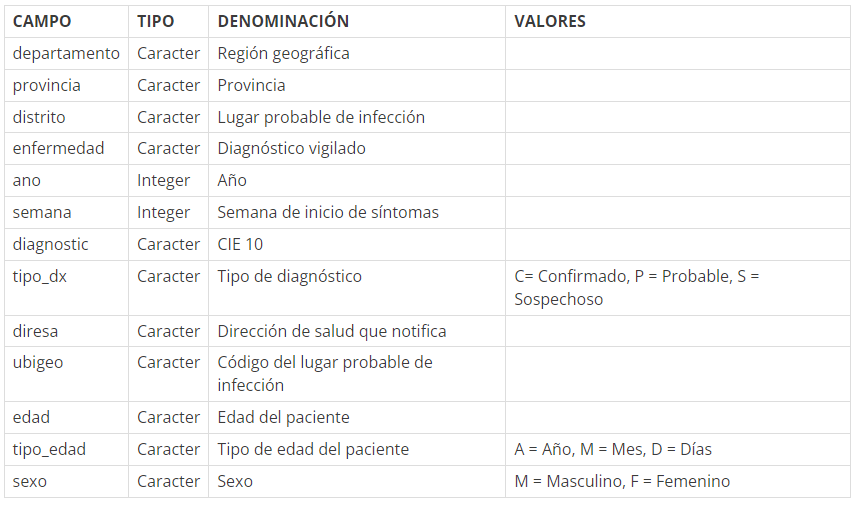

In [5]:
#Cleaning

dengue_spark_df = dengue_spark_df.na.drop()

categorical_columns = ['departamento', 'provincia', 'distrito', 'enfermedad', 'diagnostic', 'tipo_dx', 'diresa', 'ubigeo', 'tipo_edad', 'sexo']
numeric_columns = ['ano', 'semana', 'edad']

for col in categorical_columns:
    dengue_spark_df = dengue_spark_df.fillna("Desconocido", subset=[col])

#nullcol droping 0
for col in numeric_columns:
    dengue_spark_df = dengue_spark_df.fillna(0, subset=[col])

#numcol to int
for col in numeric_columns:
    dengue_spark_df = dengue_spark_df.withColumn(col, dengue_spark_df[col].cast(IntegerType()))

#SOLO rangos logicos
dengue_spark_df = dengue_spark_df.filter((F.col("ano") >= 2000) & (F.col("ano") <= 2024))
dengue_spark_df = dengue_spark_df.filter((F.col("semana") >= 1) & (F.col("semana") <= 52))
dengue_spark_df = dengue_spark_df.filter((F.col("edad") >= 0) & (F.col("edad") <= 120))

#dropear duplicados
dengue_spark_df = dengue_spark_df.dropDuplicates()

#filtrar valores validos
dengue_spark_df = dengue_spark_df.filter(F.col("tipo_dx").isin("C", "P", "S"))
dengue_spark_df = dengue_spark_df.filter(F.col("sexo").isin("M", "F"))
dengue_spark_df = dengue_spark_df.filter(F.col("tipo_edad").isin("A", "M", "D"))

#excluir valores categóricos incorrectos en 'departamento'
dengue_spark_df = dengue_spark_df.filter(F.col("departamento") != "Desconocido")
dengue_spark_df = dengue_spark_df.filter(F.col("provincia") != "Desconocido")
dengue_spark_df = dengue_spark_df.filter(F.col("distrito") != "Desconocido")

dengue_spark_df.show()

dengue_pandas_df = dengue_spark_df.toPandas()
print(dengue_pandas_df.head())

+------------+-------------+--------------------+--------------------+----+------+----------+-------+------+------+----+---------+----+
|departamento|    provincia|            distrito|          enfermedad| ano|semana|diagnostic|tipo_dx|diresa|ubigeo|edad|tipo_edad|sexo|
+------------+-------------+--------------------+--------------------+----+------+----------+-------+------+------+----+---------+----+
| LA LIBERTAD|     TRUJILLO|         EL PORVENIR|DENGUE SIN SIGNOS...|2000|    23|     A97.0|      P|  13.0|130102|   3|        A|   F|
| LA LIBERTAD|     TRUJILLO|         EL PORVENIR|DENGUE SIN SIGNOS...|2000|    26|     A97.0|      P|  13.0|130102|  21|        A|   F|
| LA LIBERTAD|     TRUJILLO|         EL PORVENIR|DENGUE SIN SIGNOS...|2000|    26|     A97.0|      P|  13.0|130102|  28|        A|   M|
| LA LIBERTAD|     TRUJILLO|            TRUJILLO|DENGUE SIN SIGNOS...|2000|    25|     A97.0|      P|  13.0|130101|   4|        A|   M|
|      LORETO|ALTO AMAZONAS|          YURIMAGUAS

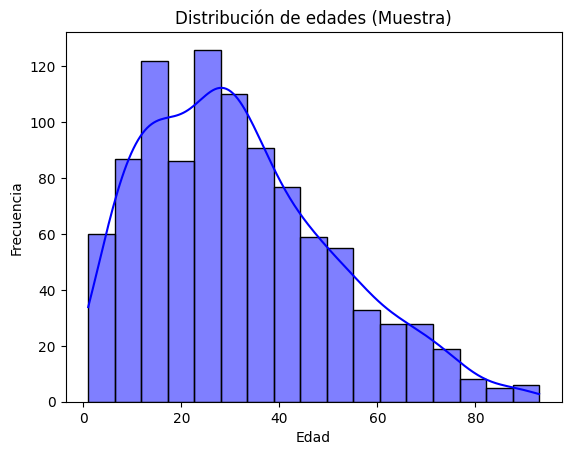

In [29]:
# Seleccionar una muestra aleatoria
muestra = dengue_pandas_df.sample(1000, random_state=42)

# Histograma de distribución de edades
sns.histplot(muestra['edad'], kde=True, color='blue')
plt.title('Distribución de edades (Muestra)')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

<ipython-input-31-84d5ff024516>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




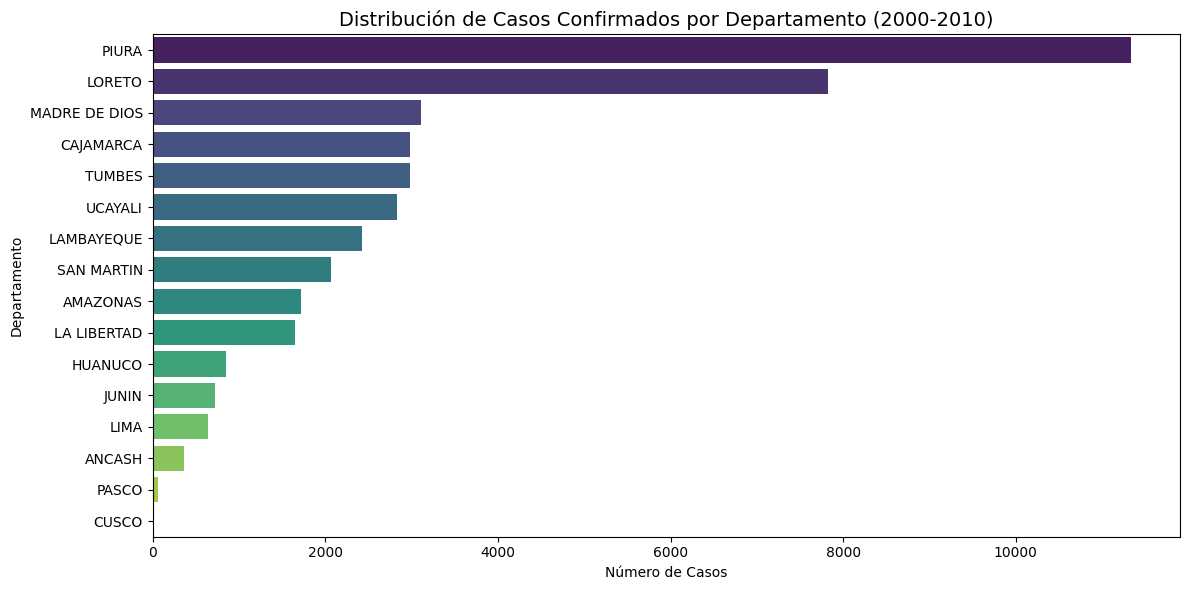

In [31]:
#filtra casos confirmados entre 2000 y 2010
casos_confirmados = dengue_pandas_df[(dengue_pandas_df['tipo_dx'] == 'C') &
                                     (dengue_pandas_df['ano'] >= 2000) &
                                     (dengue_pandas_df['ano'] <= 2010)]

departamento_counts = casos_confirmados['departamento'].value_counts().reset_index()
departamento_counts.columns = ['Departamento', 'Casos']

plt.figure(figsize=(12, 6))
sns.barplot(data=departamento_counts, x='Casos', y='Departamento', palette='viridis')
plt.title('Distribución de Casos Confirmados por Departamento (2000-2010)', fontsize=14)
plt.xlabel('Número de Casos')
plt.ylabel('Departamento')
plt.tight_layout()
plt.show()


In [32]:
# Top 10 departamentos con más casos (independientemente del estado del caso)
casos_departamento = dengue_pandas_df['departamento'].value_counts().head(10).reset_index()
casos_departamento.columns = ['Departamento', 'Casos']

fig = px.bar(
    casos_departamento,
    x='Departamento',
    y='Casos',
    title='Top 10 departamentos con más casos',
    color='Casos',
    labels={'Casos': 'Número de casos'}
)
fig.show()

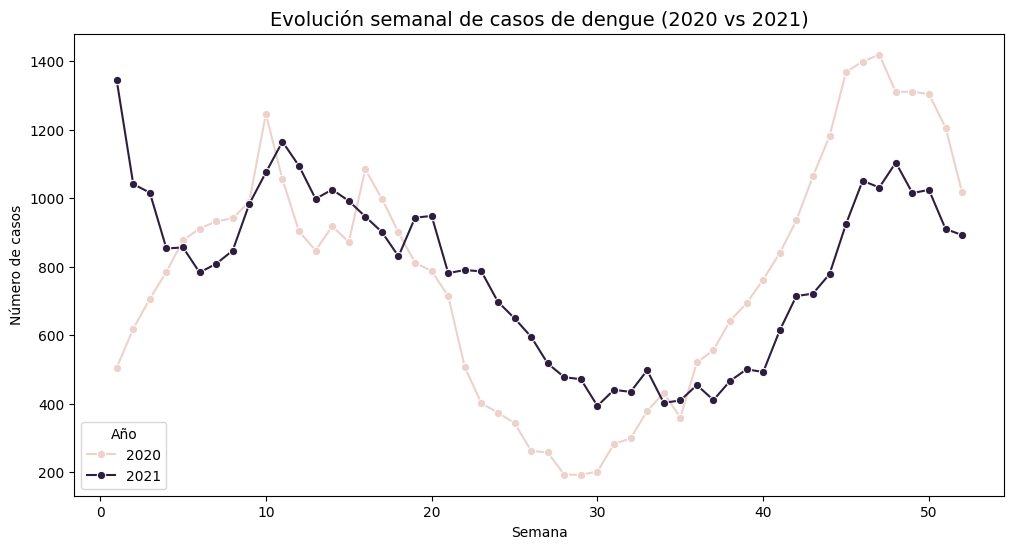

In [33]:
# Filtrar por año específico (ejemplo: 2020 y 2021)
filtro_anos = dengue_pandas_df[(dengue_pandas_df['ano'] == 2020) | (dengue_pandas_df['ano'] == 2021)]
evolucion_casos = filtro_anos.groupby(['ano', 'semana']).size().reset_index(name='casos')

plt.figure(figsize=(12, 6))
sns.lineplot(data=evolucion_casos, x='semana', y='casos', hue='ano', marker='o')
plt.title('Evolución semanal de casos de dengue (2020 vs 2021)', fontsize=14)
plt.xlabel('Semana')
plt.ylabel('Número de casos')
plt.legend(title='Año')
plt.show()

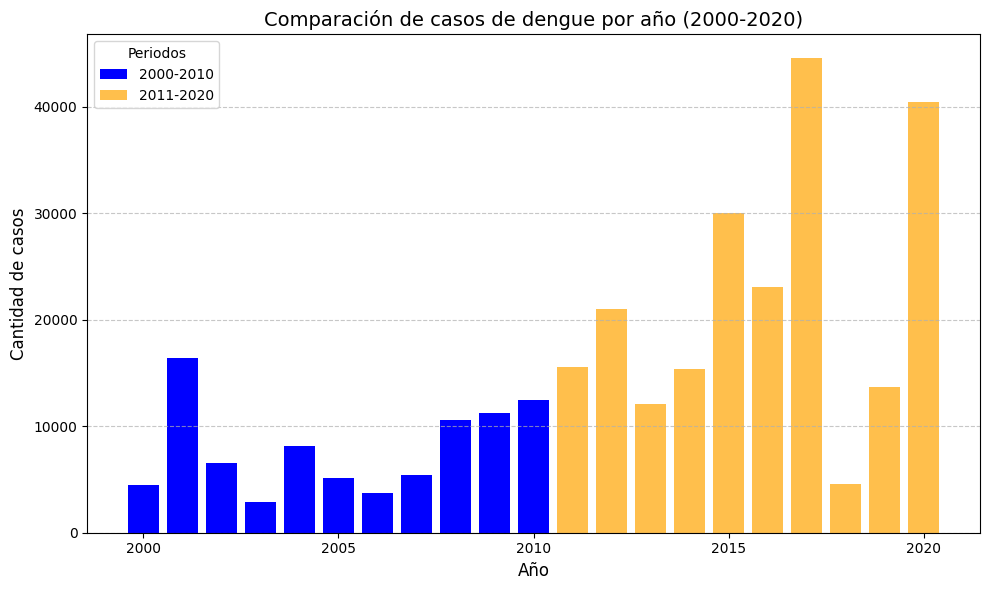

In [35]:
#filtro
periodo_1 = dengue_pandas_df[(dengue_pandas_df['ano'] >= 2000) & (dengue_pandas_df['ano'] <= 2010)]
periodo_2 = dengue_pandas_df[(dengue_pandas_df['ano'] >= 2011) & (dengue_pandas_df['ano'] <= 2020)]

#cuenta
casos_periodo_1 = periodo_1.groupby('ano').size()
casos_periodo_2 = periodo_2.groupby('ano').size()

fig, ax = plt.subplots(figsize=(10, 6))
#periodo
ax.bar(casos_periodo_1.index, casos_periodo_1.values, color='blue', label='2000-2010')
ax.bar(casos_periodo_2.index, casos_periodo_2.values, color='orange', label='2011-2020', alpha=0.7)

ax.set_title('Comparación de casos de dengue por año (2000-2020)', fontsize=14)
ax.set_xlabel('Año', fontsize=12)
ax.set_ylabel('Cantidad de casos', fontsize=12)
ax.legend(title="Periodos", fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<ipython-input-36-52170dcf43e9>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




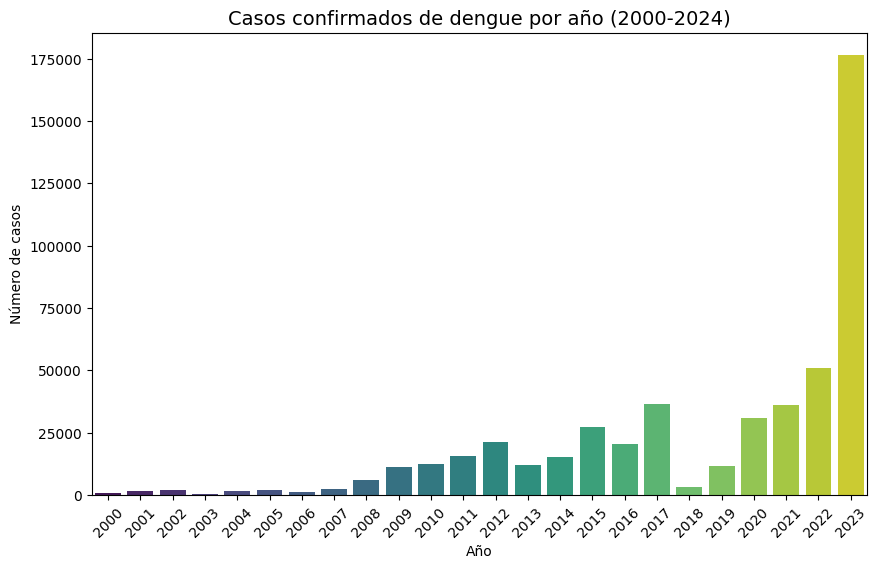

In [36]:
# Filtrar solo casos confirmados
dengue_confirmados = dengue_pandas_df[dengue_pandas_df['tipo_dx'] == 'C']

# Casos confirmados por año
casos_por_ano = dengue_confirmados.groupby('ano').size().reset_index(name='casos')

plt.figure(figsize=(10, 6))
sns.barplot(data=casos_por_ano, x='ano', y='casos', palette='viridis')
plt.title('Casos confirmados de dengue por año (2000-2024)', fontsize=14)
plt.xlabel('Año')
plt.ylabel('Número de casos')
plt.xticks(rotation=45)
plt.show()

In [10]:
from folium.plugins import HeatMap

dengue_2020 = dengue_pandas_df[dengue_pandas_df['ano'] == 2020]
departamento_counts_2020 = dengue_2020.groupby('departamento').size().reset_index(name='Casos')

departamento_coords = {
    'AMAZONAS': [-5.0739, -78.0433],
    'ANCASH': [-9.5284, -77.5289],
    'APURIMAC': [-13.6365, -72.8813],
    'AREQUIPA': [-16.4090, -71.5375],
    'AYACUCHO': [-13.1588, -74.2236],
    'CAJAMARCA': [-7.1617, -78.5003],
    'CALLAO': [-12.0566, -77.1181],
    'CUSCO': [-13.5319, -71.9675],
    'HUANCAVELICA': [-12.7870, -74.9712],
    'HUANUCO': [-9.9306, -76.2422],
    'ICA': [-14.0678, -75.7286],
    'JUNIN': [-11.1580, -75.9996],
    'LA LIBERTAD': [-8.1117, -79.0288],
    'LAMBAYEQUE': [-6.7714, -79.8409],
    'LIMA': [-12.0464, -77.0428],
    'LORETO': [-3.7491, -73.2538],
    'MADRE DE DIOS': [-12.5933, -69.1895],
    'MOQUEGUA': [-17.1941, -70.9329],
    'PASCO': [-10.6844, -76.2569],
    'PIURA': [-5.1945, -80.6328],
    'PUNO': [-15.8402, -70.0219],
    'SAN MARTIN': [-6.5120, -76.4328],
    'TACNA': [-18.0127, -70.2533],
    'TUMBES': [-3.5669, -80.4515],
    'UCAYALI': [-8.3792, -74.5539]
}

m = folium.Map(location=[-9.1900, -75.0152], zoom_start=5)
heat_data = []

for index, row in departamento_counts_2020.iterrows():
    departamento = row['departamento']
    casos = row['Casos']
    if departamento in departamento_coords:
        latitude, longitude = departamento_coords[departamento]
        heat_data.append([latitude, longitude, casos])
if heat_data:
    HeatMap(heat_data, radius=15, blur=10, max_zoom=10).add_to(m)

m

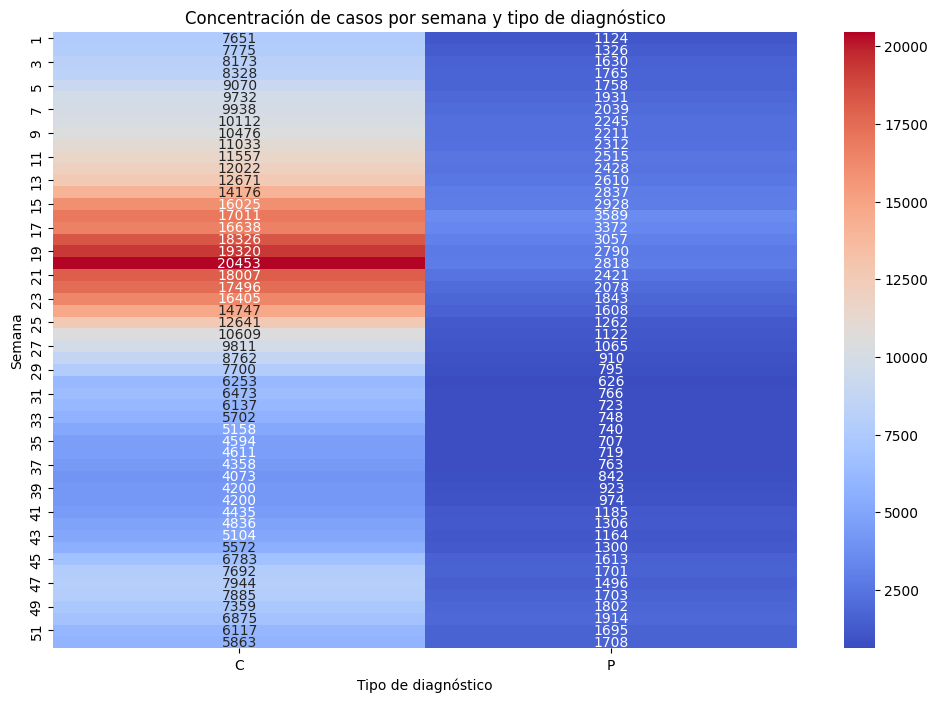

In [38]:
# Crear tabla pivote para el heatmap
heatmap_data = dengue_pandas_df.pivot_table(index='semana', columns='tipo_dx', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d')
plt.title('Concentración de casos por semana y tipo de diagnóstico')
plt.xlabel('Tipo de diagnóstico')
plt.ylabel('Semana')
plt.show()

In [39]:
# Filtrar datos para los años entre 2020 y 2024
dengue_filtrado = dengue_pandas_df[(dengue_pandas_df['ano'] >= 2020) & (dengue_pandas_df['ano'] <= 2024)]

# Contar tipos de diagnóstico
tipo_diagnostico_filtrado = dengue_filtrado['tipo_dx'].value_counts()

# Colores para los tipos de diagnóstico
colores = {
    'C': 'blue',  # Confirmados
    'P': 'orange',  # Probables
    'S': 'green'   # Sospechosos
}

# Gráfico de torta
fig = px.pie(
    values=tipo_diagnostico_filtrado.values,
    names=tipo_diagnostico_filtrado.index,
    title='Distribución de tipos de diagnóstico (2020-2024)',
    color=tipo_diagnostico_filtrado.index,
    color_discrete_map=colores
)

fig.show()

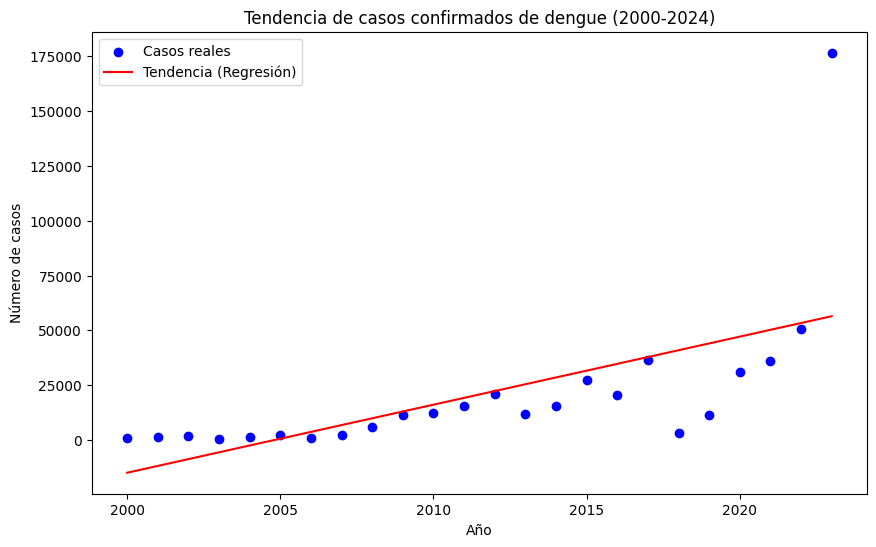

In [40]:
from sklearn.linear_model import LinearRegression

# Preparar datos
regresion_data = dengue_confirmados.groupby('ano').size().reset_index(name='casos')
X = regresion_data['ano'].values.reshape(-1, 1)
y = regresion_data['casos']

# Modelo de regresión
modelo = LinearRegression()
modelo.fit(X, y)

# Predicciones
predicciones = modelo.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Casos reales')
plt.plot(X, predicciones, color='red', label='Tendencia (Regresión)')
plt.title('Tendencia de casos confirmados de dengue (2000-2024)')
plt.xlabel('Año')
plt.ylabel('Número de casos')
plt.legend()
plt.show()